## Model 1: Multiclass Classification

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

from keras import metrics
import keras_tuner as kt

tf.get_logger().setLevel('INFO')


In [2]:
# subsetted dataset
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data1 = pickle.load(f)

print(data1.keys())

# full dataset
with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data2 = pickle.load(f)

print(data2.keys())

dict_keys(['X_train_sub', 'y_train_sub', 'X_val_sub', 'y_val_sub', 'classes_sub'])
dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'classes'])


In [3]:
# subsetted dataset
X_train_sub_images = data1["X_train_sub"]
y_train_sub = data1["y_train_sub"]
X_val_sub_images = data1["X_val_sub"]
y_val_sub = data1["y_val_sub"]
classes_sub = data1["classes_sub"]

# full dataset
X_train_images = data2["X_train"]
y_train = data2["y_train"]
X_val_images = data2["X_val"]
y_val = data2["y_val"]
X_test_images = data2["X_test"]
y_test = data2["y_test"]
classes = data2["classes"]

In [4]:
# subsetted dataset
print("X_train_sub:", X_train_sub_images.shape)
print("y_train_sub:", y_train_sub.shape)
print("X_val_sub:", X_val_sub_images.shape)
print("y_val_sub:", y_val_sub.shape)
print(classes_sub)

# full dataset
print("\nX_train:", X_train_images.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val_images.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test_images.shape)
print("y_test:", y_test.shape)

X_train_sub: (1000, 64, 64, 3)
y_train_sub: (1000,)
X_val_sub: (388, 64, 64, 3)
y_val_sub: (388,)
['flat' 'german_short' 'american_staffordshire_terrier' 'ibizan_hound'
 'cairn' 'kerry_blue_terrier' 'maltese_dog' 'bedlington_terrier'
 'english_setter' 'sussex_spaniel']

X_train: (12000, 64, 64, 3)
y_train: (12000,)
X_val: (4290, 64, 64, 3)
y_val: (4290,)
X_test: (4290, 64, 64, 3)
y_test: (4290,)


In [5]:
# Prep image data for training

# flatten array for subset dataset
X_train_sub = X_train_sub_images.reshape(X_train_sub_images.shape[0], -1)
X_val_sub = X_val_sub_images.reshape(X_val_sub_images.shape[0], -1)

print("X_train_sub is now:", X_train_sub.shape)
print("X_val_sub is now:", X_val_sub.shape)

# flatten array for full dataset
X_train = X_train_images.reshape(X_train_images.shape[0], -1)
X_val = X_val_images.reshape(X_val_images.shape[0], -1)
X_test = X_test_images.reshape(X_test_images.shape[0], -1)

print("\nX_train is now:", X_train.shape)
print("X_val is now:", X_val.shape)
print("X_test is now:", X_test.shape)

X_train_sub is now: (1000, 12288)
X_val_sub is now: (388, 12288)

X_train is now: (12000, 12288)
X_val is now: (4290, 12288)
X_test is now: (4290, 12288)


### First, we will train our logistic regression model for multiclass classification on our smaller subsetted data.

In [6]:
# prep subset labels for training
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train_sub)

print(y_train_sub[0:5]) # before encoding
y_train_sub = encoder.transform(y_train_sub)
y_val_sub = encoder.transform(y_val_sub)
print(y_train_sub[0:5]) # after encoding

['ibizan_hound' 'english_setter' 'german_short' 'bedlington_terrier'
 'cairn']
[6 3 5 1 2]


In [7]:
# calculate baseline accuracy for subsetted data

# get majority class of y_val_sub dataset
majority_class_sub = np.bincount(y_val_sub).argmax()
print(majority_class_sub)
print(encoder.inverse_transform([majority_class_sub])[0])

# compute baseline accuracy
baseline_pred_sub = np.full_like(y_val_sub, fill_value=majority_class_sub)
baseline_accuracy_sub = np.mean(baseline_pred_sub == y_val_sub)
print(f"Baseline Accuracy of Subsetted Data: {baseline_accuracy_sub:.4f}")


8
maltese_dog
Baseline Accuracy of Subsetted Data: 0.1959


In [8]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

In [9]:
# Build and Compile Multiclass Classification Model

def build_model(num_features, learning_rate, num_classes):
  """Build a TF multiclass logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=num_classes,                                 # output dim
      input_shape=[num_features],               # input dim
      use_bias=True,                            # use a bias (intercept) param
      activation='softmax',                     # for multiclass classification
      kernel_initializer=	'glorot_uniform',   
      bias_initializer='zeros',     
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
  )
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                122890    
                                                                 
Total params: 122890 (480.04 KB)
Trainable params: 122890 (480.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
32/32 [==============================] - 0s 3ms/step - loss: 2.3297 - accuracy: 0.1440 - val_loss: 2.2082 - val_accuracy: 0.1649
Epoch 2/40
32/32 [==============================] - 0s 1ms/step - loss: 2.1072 - accuracy: 0.2290 - val_loss: 2.1521 - val_accuracy: 0.1959
Epoch 3/40
32/32 [==============================] - 0s 1ms/step - loss: 2.0452 - accuracy: 0.2500 - val_loss: 2.1137 - val_accuracy: 0.2397
Epoch 4/40
32/32 [==============================] - 0s 1ms/step - loss: 1.9910 - accuracy: 0.2670 - val_loss: 1.9865 - 

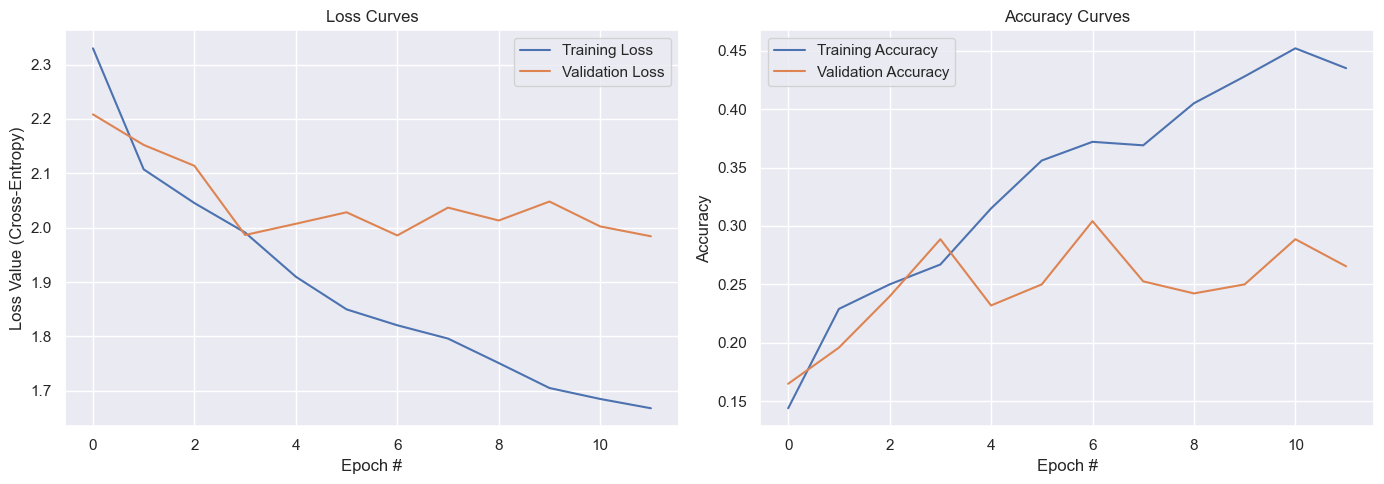

13/13 [==============================] - 0s 408us/step - loss: 1.9857 - accuracy: 0.3041
Training accuracy:  0.390
Validation accuracy:  0.304
Generalization Gap:  0.086


In [10]:
## train model on subsetted dataset
# set random seed
import random
random.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

# build model
model1 = build_model(12288, 0.0001, num_classes=10)
print(model1.summary())

# train model
num_epochs = 40
history1 = model1.fit(
    X_train_sub,
    y_train_sub,
    validation_data=(X_val_sub, y_val_sub),
    epochs=num_epochs,
    callbacks=[early_stopping],
    batch_size=32
)

# create loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 5))

ax1.plot(history1.history['loss'], label='Training Loss')
ax1.plot(history1.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss Value (Cross-Entropy)')
ax1.legend()

ax2.plot(history1.history['accuracy'], label='Training Accuracy')
ax2.plot(history1.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()

plt.show()

train_acc = model1.evaluate(X_train_sub, y_train_sub)[1]
val_acc = model1.evaluate(X_val_sub, y_val_sub)[1]
gap = train_acc - val_acc

print(f'Training accuracy: {train_acc: .3f}')
print(f'Validation accuracy: {val_acc: .3f}')
print(f'Generalization Gap: {gap: .3f}')


### Next, we will train our model on the full dataset

In [11]:
# prep full dataset labels for training
encoder.fit(y_train)

print(y_train[0:5]) # before encoding
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)
print(y_train[0:5]) # after encoding

['irish_wolfhound' 'brittany_spaniel' 'redbone' 'boxer' 'pekinese']
[59 24 89 21 85]


In [12]:
# calculate baseline accuracy for full dataset

# get majority class of y_test dataset
majority_class = np.bincount(y_test).argmax()
print(majority_class)
print(encoder.inverse_transform([majority_class])[0])

# compute majority baseline accuracy
baseline_pred = np.full_like(y_test, fill_value=majority_class)
baseline_accuracy = np.mean(baseline_pred == y_test)
print(f"Majority Baseline Accuracy of Full Data: {baseline_accuracy:.4f}")

# compute random guessing baseline accuracy
random_preds = np.random.randint(0, 120, size=len(y_test))
random_accuracy = np.mean(random_preds == y_test)
print(f"Random Guessing Accuracy of Full Data: {random_accuracy:.4f}")

73
maltese_dog
Majority Baseline Accuracy of Full Data: 0.0177
Random Guessing Accuracy of Full Data: 0.0068


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               1474680   
                                                                 
Total params: 1474680 (5.63 MB)
Trainable params: 1474680 (5.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
188/188 [==============================] - 1s 5ms/step - loss: 4.8703 - accuracy: 0.0156 - val_loss: 4.7177 - val_accuracy: 0.0224
Epoch 2/40
188/188 [==============================] - 1s 4ms/step - loss: 4.5941 - accuracy: 0.0356 - val_loss: 4.6910 - val_accuracy: 0.0252
Epoch 3/40
188/188 [==============================] - 1s 4ms/step - loss: 4.4461 - accuracy: 0.0518 - val_loss: 4.6755 - val_accuracy: 0.0296
Epoch 4/40
188/188 [==============================] - 1s 4ms/step - loss: 4.3301 - accuracy: 0.0674 - val_loss: 4.6

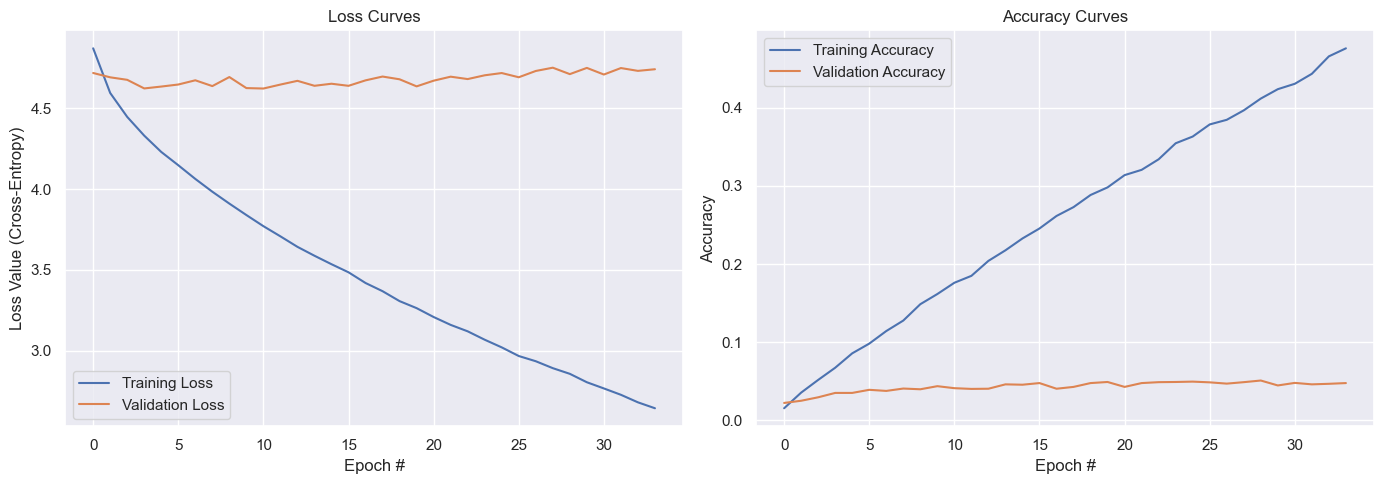

135/135 [==============================] - 0s 679us/step - loss: 4.7107 - accuracy: 0.0510
Training accuracy:  0.445
Validation accuracy:  0.051
Generalization Gap:  0.394


In [13]:
## train model on full dataset

# set random seed
import random
random.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

# build model
model2 = build_model(12288, 0.0001, num_classes=120)
print(model2.summary())

# train model
num_epochs = 40
history2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    callbacks=[early_stopping],
    batch_size=64
)

# create loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 5))

ax1.plot(history2.history['loss'], label='Training Loss')
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss Value (Cross-Entropy)')
ax1.legend()

ax2.plot(history2.history['accuracy'], label='Training Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()

plt.show()

train_acc = model2.evaluate(X_train, y_train)[1]
val_acc = model2.evaluate(X_val, y_val)[1]
gap = train_acc - val_acc

print(f'Training accuracy: {train_acc: .3f}')
print(f'Validation accuracy: {val_acc: .3f}')
print(f'Generalization Gap: {gap: .3f}')


In [14]:
# Evaluate final model on test dataset

probs_train = model2.predict(X_train)
probs_test = model2.predict(X_test)

y_pred_train = np.argmax(probs_train, axis=1)
y_pred_test = np.argmax(probs_test, axis=1)

train_accuracy = np.sum(y_pred_train == y_train) / len(y_train)
test_accuracy = np.sum(y_pred_test == y_test) / len(y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

135/135 [==============================] - 0s 627us/step
Train Accuracy: 0.445
Test Accuracy: 0.04755244755244755


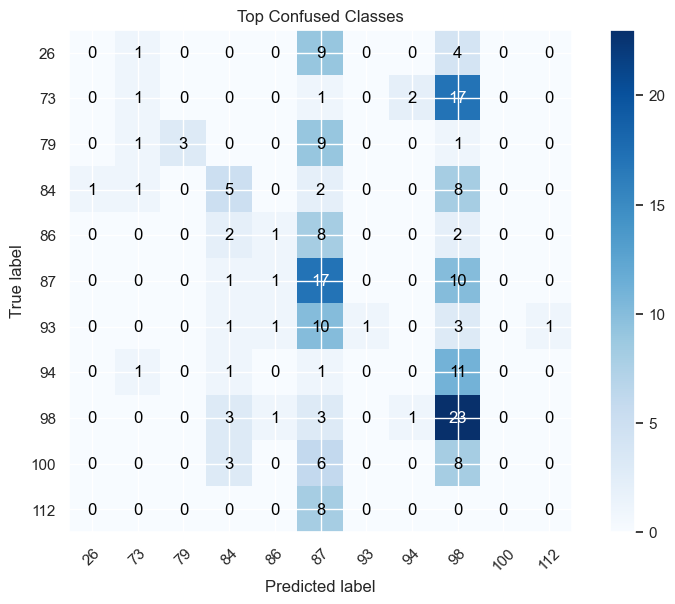

In [16]:
# Since we have too many classes, we'll plot the top most confused classes
cm = confusion_matrix(y_test, y_pred_test)

# Remove diagonal (correct predictions) to isolate confusion
cm_off_diag = cm.copy()
np.fill_diagonal(cm_off_diag, 0)

# Find top 10 confused class pairs (with highest off-diagonal values)
flat_indices = np.argsort(cm_off_diag.ravel())[::-1][:10]
top_confused_pairs = [np.unravel_index(i, cm.shape) for i in flat_indices]

# Get unique class labels involved in top confused pairs
top_labels = sorted(set(i for pair in top_confused_pairs for i in pair))

# Slice a smaller confusion matrix using only those top labels
cm_top = cm[np.ix_(top_labels, top_labels)]

# Plot matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_top, interpolation='nearest', cmap='Blues')
plt.title("Top Confused Classes")
plt.colorbar()
tick_marks = np.arange(len(top_labels))
plt.xticks(tick_marks, top_labels, rotation=45)
plt.yticks(tick_marks, top_labels)

# Overlay the numbers
for i in range(len(top_labels)):
    for j in range(len(top_labels)):
        val = cm_top[i, j]
        plt.text(j, i, format(val, 'd'), ha="center", va="center",
                 color="white" if val > cm_top.max() / 2. else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Show image examples for each label that appeared in the subsetted confusion matrix
# Use the top_labels from the confusion matrix analysis in cell 17
print("Top confused labels from confusion matrix:", top_labels)

# Get the actual class names for these labels
top_label_names = encoder.inverse_transform(top_labels)
print("Top confused class names:", top_label_names)


# im having a hard time showing image data

Top confused labels from confusion matrix: [26, 73, 79, 84, 86, 87, 93, 94, 98, 100, 112]
Top confused class names: ['cairn' 'maltese_dog' 'norfolk_terrier' 'papillon' 'pembroke'
 'pomeranian' 'saluki' 'samoyed' 'sealyham_terrier' 'shih' 'vizsla']


### Conclusion:

Our multi-class logistic regression models were able to perform better than baseline for both the subsetted dataset and the full dataset. As expected, we were only able to get so far with overall accuracy and generalization, since logistic regression models do not have the ability to capture spatial or hierarchical patterns in image data.

For this approach, the subsetted model overall performed much better, which aligns with our expectations. It is harder to accurately classify 120 classes vs 10 classes, especially when the model has limited capacity to learn complex patterns in image data.

---
**RESULTS**

**Model Performance on Subsetted Dataset**

- Majority Baseline Accuracy: 0.1959  
- Training Accuracy: 0.390  
- Validation Accuracy: 0.304  
- Generalization Gap: 0.086

---

**Model Performance on Full Dataset**

- Majority Baseline Accuracy: 0.0177  
- Random Guessing Accuracy: 0.0068  
- Training Accuracy: 0.445  
- Validation Accuracy: 0.051  
- Generalization Gap: 0.394